# Relazione secondo progetto algoritmi avanzati

Francesca Meneghello 1227939 <br />
Leonardo Pratesi 1237582

## 1. Introduzione

Per la rappresentazione dei grafi abbiamo utilizzato una matrice di adiacenza *n x n*, con n numero totale di nodi. Nella posizione *( i , j )* della matrice troviamo il peso dell'arco che collega il nodo *i* con il nodo *j*
se esiste tale arco altrimento troviamo il valore *null*. <br/>
Abbiamo deciso di utilizzare la matrice di adiacenza dato che il problema del commesso viaggiatore viene rappresentato con un grafo non orientato, pesato e completo G = (V,E) dove i vertici sono le città ed il peso dell’arco {u,v} è uguale alla distanza da u a v. Attraverso la matrice quindi è stato più facile rappresentare un grafo completo e accedere al peso degl'archi in tempo costante senza scorrere una lista di adiacenza. <br/>
La funzione per il calcolo delle distanze e la creazione delle matrici sono le stesse per tutti gli algoritmi da noi  implementati, prende in input il nome del file e in base al formato crea la matrice, come l'esempio riportato sotto. <br/> ##### aggiungere qualcosa per sul parseFile? ########### <br/>
Per quanto riguarda le euristiche costruttive abbiamo deciso di svolgere sia la *Closest Insertion* che la *Farthest Insertion* dato che differenziano solo nella fase di selezione, in cui la prima minimizza il valore *δ(k,C)* mentre la seconda lo massimizza. 

In [2]:
import utilities as ut
#### lettura file burma14.tsp e creazione matrice ##########
matrix=ut.parseFile('burma14.tsp')
print(matrix)

{'NAME': 'burma14', 'TYPE': 'TSP', 'COMMENT': '14-Staedte in Burma (Zaw Win)', 'DIMENSION': '14', 'EDGE_WEIGHT_TYPE': 'GEO', 'EDGE_WEIGHT_FORMAT': 'FUNCTION', 'DISPLAY_DATA_TYPE': 'COORD_DISPLAY'}
[[   1  153  510  706  966  581  455   70  160  372  157  567  342  398]
 [ 153    1  422  664  997  598  507  197  311  479  310  581  417  376]
 [ 510  422    1  289  744  390  437  491  645  880  618  374  455  211]
 [ 706  664  289    1  491  265  410  664  804 1070  768  259  499  310]
 [ 966  997  744  491    1  400  514  902  990 1261  947  418  635  636]
 [ 581  598  390  265  400    1  168  522  634  910  593   19  284  239]
 [ 455  507  437  410  514  168    1  389  482  757  439  163  124  232]
 [  70  197  491  664  902  522  389    1  154  406  133  508  273  355]
 [ 160  311  645  804  990  634  482  154    1  276   43  623  358  498]
 [ 372  479  880 1070 1261  910  757  406  276    1  318  898  633  761]
 [ 157  310  618  768  947  593  439  133   43  318    1  582  315  464]


## 2. Algoritmo esatto di Held e Karp

In [1]:
import utilities as ut

#recursive version of the Held Karp algorithm
#receives a matrix of distances and returns the min circular path traversing al nodes once
def calcHeldKarpRecursiveVersion(dmatrix):
    dim = len(dmatrix)
    dist = {}
    py = {}   
    
    #recursive function to be called
    def HK_Visit(v, S):
        #print(v,encToList(S)) #Debug
        #case base
        if 1<<v == S:
            return dmatrix[0,v]

        #already calculated distance
        elif (v,S) in dist.keys():
            return dist[v,S]

        else:
            mindist = 2147483647
            minprec = -1

            prevsub = S & ~ (1 << v)
            listanodi = encToList(prevsub)

            for u in listanodi:
                distance = HK_Visit(u, prevsub)

                if distance + dmatrix[u,v] < mindist:
                    mindist = distance + dmatrix[u,v]
                    #print(v, encToList(S))
                    minprec = u
            
            dist[v,S] = mindist
            py[v,S] = minprec

            return mindist

    #support function that searches in py={} and reconstructs the whole path sequence
    def build_path():
        percorso = []
        k=0
        S=2**dim-1
        while len(percorso) < len(dmatrix)-1:
            temp = py[(k,S)]
            percorso.append(temp)
            S = S & ~ (1 << k)
            k = temp
        
        percorso.append(0)
        
        return percorso


    risultato = HK_Visit(0, 2**dim-1) #(1,V)
    #indexes were used 1 off so 1 add one to all so they represent the real nodes name
    #print(list(reversed(list(map(lambda x: x+1, build_path())))), risultato)
    return list(reversed(list(map(lambda x: x+1, build_path())))), risultato


#convert the binary encoding in the corresponding list
def encToList(binary):
    t = bin(binary)[2:]
    sett = []
    num=0
    for i in t[::-1]:
        if i == '1':
            sett.append(num)
        num += 1
    return sett

a = ut.parseFile('burma14.tsp')
print('heldkarp: ', calcHeldKarpRecursiveVersion(a))

{'NAME': 'burma14', 'TYPE': 'TSP', 'COMMENT': '14-Staedte in Burma (Zaw Win)', 'DIMENSION': '14', 'EDGE_WEIGHT_TYPE': 'GEO', 'EDGE_WEIGHT_FORMAT': 'FUNCTION', 'DISPLAY_DATA_TYPE': 'COORD_DISPLAY'}
heldkarp:  ([1, 10, 9, 11, 8, 13, 7, 12, 6, 5, 4, 3, 14, 2], 3323)


## 3. Euristiche costruttive

### 3.1 Closest Insertion

In [2]:
import utilities as ut

def closestInsertion(dmatrix):
    #init
    dim = len(dmatrix)
    partial = []
    remaining = list(range(dim))

    #array that holds the path
    partial.append(0)
    #array that holds the remanining nodes
    remaining.remove(0)


    #stop the cicle when there are no more nodes to be added
    while remaining:

        toadd = -1
        mindist = 2147483647

        #get the node nearest to the partial graph
        for j in remaining:
            mindist2 = 2147483647
            for k in partial:
                if dmatrix[j,k] < mindist:
                    mindist2 = dmatrix[j,k]
            
            if mindist2 < mindist :
                toadd = j
                mindist = mindist2

        # remove the node that satisfies the condition of minimal distance
        remaining.remove(toadd)

        k = toadd
        pos = -1
        valnearest = 21474836474
        
        #find the correct position in which insert the node 
        if len(partial) == 1:
                nearest=1
        else:
            minimo=valnearest
            #dove inserire il nodo k dopo aver trovato la soluzione
            for i in range(0, len(partial)): #controllo le coppie di archi all'interno di C
                if i+1< len(partial):
                    val=dmatrix[partial[i],k] + dmatrix[k,partial[i+1]] - dmatrix[partial[i], partial[i+1]]
                    j=i+1
                else:
                    val=dmatrix[partial[i],k] + dmatrix[k,partial[0]] - dmatrix[partial[i], partial[0]]
                    j=0
                if val<minimo: 
                    minimo=val
                    pos=j


        #now i know what node i have to add (toadd) and where (pos)
        partial.insert(pos, toadd)
        
    #print(partial)      

    #compute total path length
    distanceFinal =0
    for i in range(len(partial)-1):
        distanceFinal += dmatrix[partial[i],partial[i+1]]
    #add the distance of the last elemento to the first element to complete the circle
    distanceFinal += dmatrix[0, partial[-1]]

    #as i worked with nodes starting from zero , i add one to all values so i get the real ones
    return list(map(lambda x:x+1,partial)), distanceFinal

a = ut.parseFile('ulysses22.tsp')
print('closest insertion: ', closestInsertion(a))


{'NAME': 'ulysses22.tsp', 'TYPE': 'TSP', 'COMMENT': 'Odyssey of Ulysses (Groetschel/Padberg)', 'DIMENSION': '22', 'EDGE_WEIGHT_TYPE': 'GEO', 'DISPLAY_DATA_TYPE': 'COORD_DISPLAY'}
closest insertion:  ([8, 18, 4, 22, 17, 2, 3, 16, 12, 21, 20, 19, 10, 9, 11, 7, 6, 13, 14, 5, 15, 1], 7735)


### 3.2 Farthest Insertion 

L'euristica costruttiva *Farthest Insertion* , come la precedente, è composta da 3 fasi:
Inizializzazione, Selezione, Inserimento. Le ultime due fasi vengono ripetute finchè il ciclo Hamiltoniano non è stato completato. Mentre l'Inizializzazione e l'Inserimento risultano essere uguali a *Closest Insertion*, la Selezione è opposta cioè viene massimizzato il valore *δ(k,C)*. Attraverso la massimizzazione viene selezionato il vertice *k* non ancora all'interno del circuito parziale *C* che massimizza la distanza da quest'ultimo. <br/>
La selezione viene eseguita *( n - 1 )* volte per inserire tutti i vertici del grafo nel circuito parziale *C* che poi alla fine dell'algoritmo risulterà il ciclo Hamiltoniano per il grafo in input.
<br/> Complessità: <br/>
* *Inizializzazione* Ѳ(n), scorrimento di tutta la matrice alla riga 0 per trovare il minimo arco e quindi il vertice più vicino <br/>
* *Selezione* dato s numero elementi in *C* circuito parziale e *Ѳ(s)* il costo computazionale per il calcolo di *δ(k,C)*, in totale abbiamo una complessità *Ѳ((n-s) x s)* e viene eseguita (n-1) volte. <br/>
* *Inserimento* dato s numero elementi in *C* circuito parziale abbiamo *Ѳ(s)* <br/> 

In totale quindi abbiamo una complessità quasi quadratica, infatti si può notare che nei grafi più grandi, da 442 nodi in su, il tempo impiegato dall'algoritmo cresce molto velocemente.

In [1]:
import utilities as ut
import FarthestInsertion as fr #funzioni di supporto

def farthest(file_name):
    ############# LETTURA FILE ###############
    matrix=ut.parseFile(file_name)
    n=len(matrix)
    ############ VARIABILI ############
    C=[] #insieme di archi risultanti
    MAX= 9223372036854775807
    V=[] #insieme di tutti i nodi iniziali che vengono estratti man mano
    for i in range(0, n):
        V.append(i)
    ############# INIZIALIZZAZIONE ##################
    minimo= MAX
    j=-1
    for i in range(1, n):
        if matrix[0,i]<minimo:
            minimo=matrix[0,i]
            j=i
    #inserisco i primi due nodi nel circuito parziale
    C.append(0), C.append(j)
    #elimino i due nodi inseriti dall'insieme di tutti i vertici
    V.remove(0), V.remove(j)

    k=fr.selezione(V,C,matrix)#selezione del primo nodo k da inserire nel circuito parziale
    while k!=-1: #se ritorna -1 non ho più elementi da selezionare
        ########### INSERIMENTO #####################
        #arco {i, j} in C che minimizza matrix[i,k] + matrix[k,j] - matrix[i, j]
        minimo=MAX
        pos=-1 #dove inserire il nodo k dopo aver trovato la soluzione
        for i in range(0, len(C)): #controllo le coppie di archi all'interno di C
                if i+1< len(C):
                    val=matrix[C[i],k] + matrix[k,C[i+1]] - matrix[C[i], C[i+1]]
                    j=i+1
                else:
                    val=matrix[C[i],k] + matrix[k,C[0]] - matrix[C[i], C[0]]
                    j=0
                if val<minimo: 
                    minimo=val
                    pos=j
        V.remove(k) #elimino l'elemento K dall'insieme dei nodi ancora da estrarre
        C.insert(pos, k) #inserisco K tra i e j nel circuito parziale C
        k=fr.selezione(V,C,matrix)
        
    totale=fr.calcTot(C, matrix)
    return C, totale #return ciclo e soluzione finale

ciclo, tot= farthest('burma14.tsp')
fr.printCycle(ciclo)
print(tot)

{'NAME': 'burma14', 'TYPE': 'TSP', 'COMMENT': '14-Staedte in Burma (Zaw Win)', 'DIMENSION': '14', 'EDGE_WEIGHT_TYPE': 'GEO', 'EDGE_WEIGHT_FORMAT': 'FUNCTION', 'DISPLAY_DATA_TYPE': 'COORD_DISPLAY'}
11 9 10 1 2 14 3 4 5 6 12 7 13 8 
3323


## 4. Algoritmo 2-approssimato

Il calcolo dell'mst viene eseguito tramite l'algoritmo di Prim, implementato con heap binario, che prende in input il nome del file e la radice da cui far partire l'algoritmo. I risultati ottenuti risultanno diversi in base alla scelta del nodo che utilizziamo per la partenza del ciclo Hamiltoniano. Mentre il minimo albero ricoprente è sempre lo stesso indipendentemente dal nodo di partenza, quando trasformiamo l'albero in ciclo Hamiltoniano il nodo da cui partiamo gioca un ruolo importante. Per trovare il risultato migliore, infatti, abbiamo testato l'algoritmo su tutti i nodi del grafo per ogni istanza. Nell'esempio che riportiamo sotto possiamo notare che otteniamo il risultato migliore con il nodo 6. <br/>
Il costo computazionale dell'algoritmo è la somma del costo di Prim *0( m log n )* e della visita anticipata Ѳ(m),  quindi *O( m log n + m)*.

In [1]:
import utilities as ut
import approx as ap #funzioni di supporto
import Prim as pr #funzioni per il calcolo dell'mst con algortmo di Prim

def approx(file_name, root):

    #colcalo l'mst con l'algortimo di Prim, mi restituisce:
    #la matrice creata al suo interno, l'mst finale e l'ordine dei nodi estratti
    mst, matrix, extract= pr.Prim(file_name, root) 
    n= len(mst)
    
    #per ogni nodo aggiungiamo la lista dei suoi figli secondo l'ordine di estrazione di Prim
    for i in range(0, len(extract)):
        j=extract[i]
        if mst[j].pi!=None:
            r=int(mst[j].pi)
            mst[r].child.append(j)
            
    H=[] 
    #visita anticipata dell'albero, per inserire tutti i nodi in H
    ap.Preorder(mst, root, H)

    total=0
    #calcolo costo totale
    for i in range(0, n-1):
        total+= matrix[H[i], H[i+1]]
    #aggiunta ultimo arco
    total+= matrix[H[n-1], H[0]]

    return H, total
#parte dal nodo 6 del grafo che nella nostra codifica è 5, con questo nodo abbiamo il miglior
#risultato per burma14.tsp
H, total= approx('burma14.tsp', 5)
ap.printH(H)
print(total)

burma14.tsp
{'NAME': 'burma14', 'TYPE': 'TSP', 'COMMENT': '14-Staedte in Burma (Zaw Win)', 'DIMENSION': '14', 'EDGE_WEIGHT_TYPE': 'GEO', 'EDGE_WEIGHT_FORMAT': 'FUNCTION', 'DISPLAY_DATA_TYPE': 'COORD_DISPLAY'}
6 12 7 13 8 1 2 11 9 10 14 3 4 5 
3583


## 5. Tabella

Nella tabella seguente vengono messe a confronto le soluzioni, il tempo impiegato in secondi e l'errore rispetto alle soluzioni ottime di tutti gli algoritmi da noi implementati. <br/>
Per l'algoritmo 2-approssimato è stata aggiunta la colonna *Soluzione migliore* e *Soluzione media*, la prima rappresenta la soluzione migliore trovata mentre la seconda rappresenta la media delle soluzioni trovate calcolate su tutti i nodi del grafo. Possiamo osservare un'ampia differenza tra i due valori, quindi la scelta del nodo da cui far iniziare l'algoritmo 2-approssimato porta a risultati molto diversi tra loro che si avvicinano o meno alla soluzione ottima.

<img src="Tabella.png" width=850 height=800 />

Di seguito è riportato un grafico in cui vengono confrontati gli errori prodotti dalle due diverse euristiche e  dall'algoritmo 2-approssimato nel calcolo del Travelling Salesman Problem.<br/>
Come possiamo osservare dal grafico le euristiche hanno un errore decisamente più basso tranne le istanze più piccole, fino a 22 nodi, in cui le differenze sono inferiori.

<img src="barplot.png" width=850 height=800 />

## 6. Conclusioni

Dal capitolo precedente possiamo osservare come il calcolo della soluzione esatta tramite Held & Karp sia troppo oneroso già con 22 nodi e praticamente inutilizzabile per i rimanenti grafi. <br/>
Le due eristiche producono le migliori soluzioni approssimate con un errore medio circa del 10% tuttavia man mano che aumenta la dimensione del grafo il tempo impiegato risulta elevato (con 1000 nodi impiega più di 2 minuti). <br/>
Viceversa l'algoritmo 2-approssimato mantiene i tempi molto più bassi (un secondo nel caso peggiore) ma le soluzioni trovate hanno un errore più elevato. Inoltre risulta casuale in quanto la scelta del nodo da cui iniziare determina il risultato stesso. Per trovare il risultato migliore abbiamo dovuto testare l'algoritmo su tutti i nodi del grafo. <br/>
Tutto questo ci fa intuire che non esiste un algoritmo migliore dell'altro ma dobbiamo scegliere l'algoritmo in base alle priorità che ci poniamo cioè secondo il tempo o alla soluzione che vogliamo ottenere. <br/>

Di seguito riportiamo graficamente i diversi cicli Hamiltoniani creati da ogni algoritmo. <br/>
Possiamo osservare, nel caso di "burma14.tsp", che i cicli creati da Held & Karp e Farthest Insertion risultano diversi anche se il costo totale del ciclo è lo stesso, come riportato nella tabella.

### 6.1 Burma14

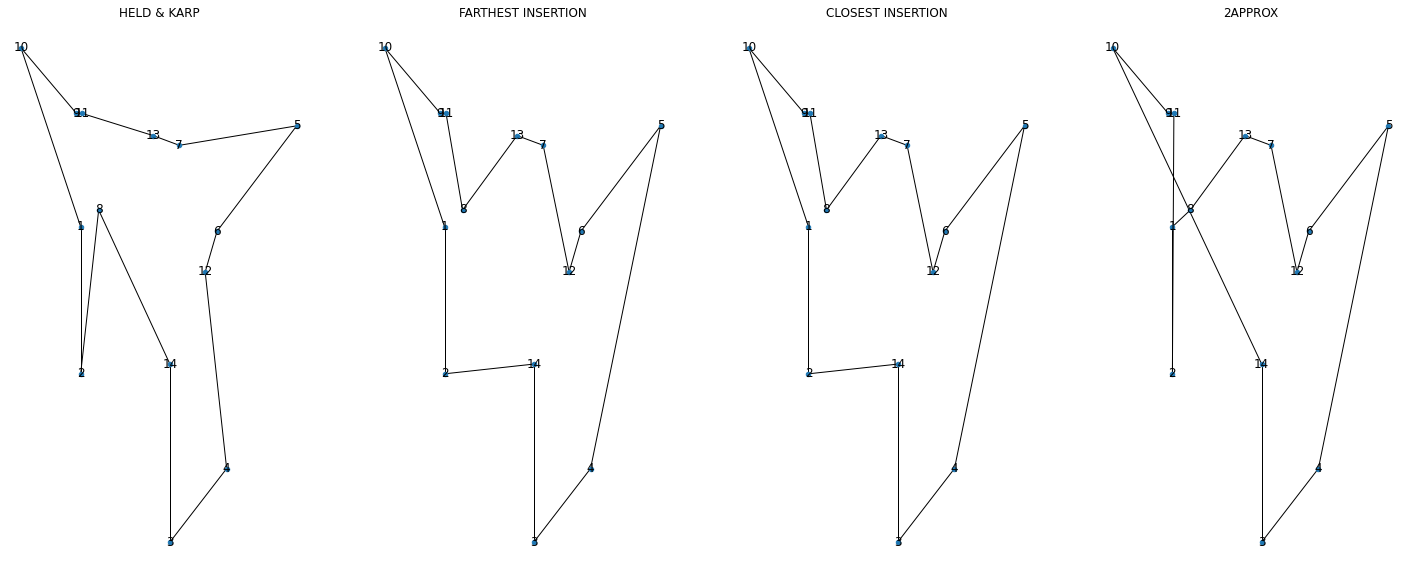

In [5]:
#burma
import DrawingTest as draw
pathburmafarthest = [11,9,10,1,2,14,3,4,5,6,12,7,13,8]
pathburmaclosest = [2, 8, 14, 3, 4, 12, 6, 5, 7, 13, 11, 9, 10, 1] #closestInsertion('burma14.tsp')[0]
pathburmaheld = [1, 10, 9, 11, 8, 13, 7, 12, 6, 5, 4, 3, 14, 2] #calcHeldKarpRecursiveVersion('burma14.tsp')[0]
path2approx = [5,6,12,7,13,8,1,2,11,9,10,14,3,4]

k=[]
k.append(pathburmaclosest)
k.append(pathburmafarthest)
k.append(pathburmaheld)
k.append(path2approx)
draw.drawPath('burma14.tsp', k)
# draw.drawPath('burma14.tsp', pathburmaclosest)
# draw.drawPath('burma14.tsp', pathburmaheld)
# draw.drawPath('burma14.tsp', path2approx)

### 6.2 Berlin52

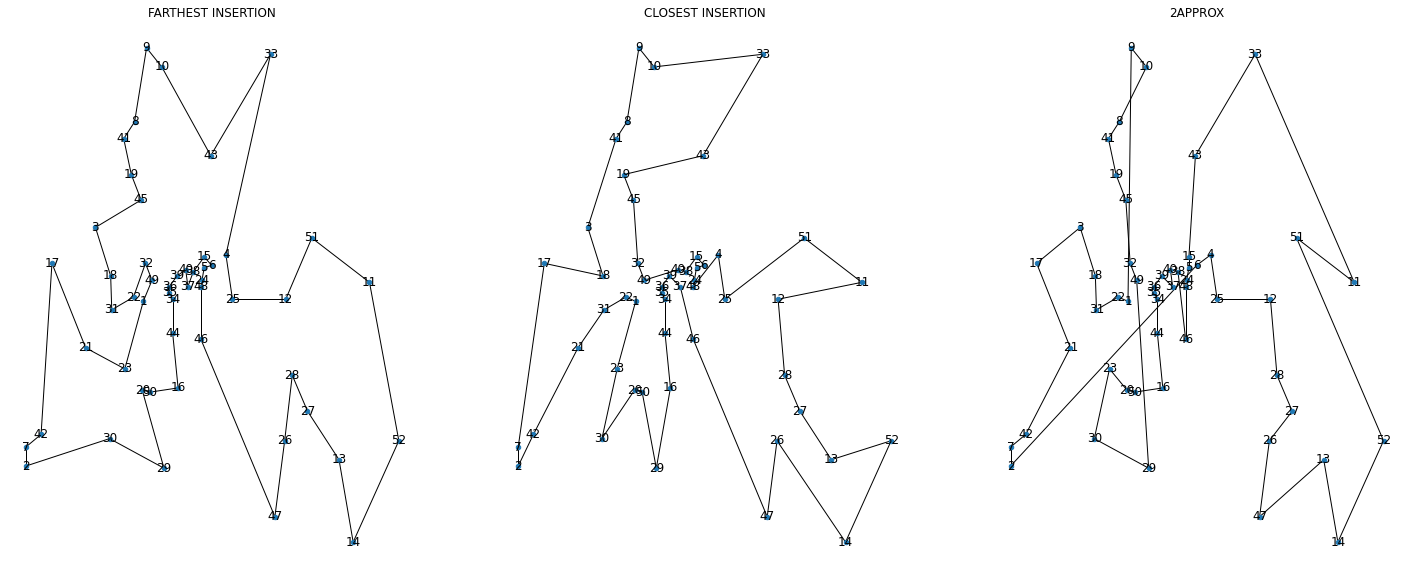

In [6]:
#berlin52 no held
import DrawingTest as draw
pathberlinfarth = [32,49,1,23,21,17,42,7,2,30,29,20,50,16,44,34,35,36,39,40,37,38,15,6,5,24,48,46,47,26,28,27,13,14,52,11,51,12,25,4,33,43,10,9,8,41,19,45,3,18,31,22]
pathberlinclos = [22, 31, 21, 42, 2, 7, 17, 18, 3, 41, 8, 9, 10, 33, 43, 19, 45, 32, 49, 40, 38, 15, 6, 5, 24, 48, 4, 25, 51, 11, 12, 28, 27, 13, 52, 14, 26, 47, 46, 37, 39, 36, 35, 34, 44, 16, 29, 50, 20, 30, 23, 1]
path2approxberlin = [33,43,15,5,24,48,46,38,40,37,39,36,35,34,44,16,50,20,23,30,29,49,32,45,19,41,8,10,9,1,22,31,18,3,17,21,42,7,2,6,4,25,12,28,27,26,47,13,14,52,51,11]

k=[]
k.append(pathberlinfarth)
k.append(pathberlinclos)
k.append(path2approxberlin)
draw.drawPath('berlin52.tsp', k)

### 6.3 Ulysses22

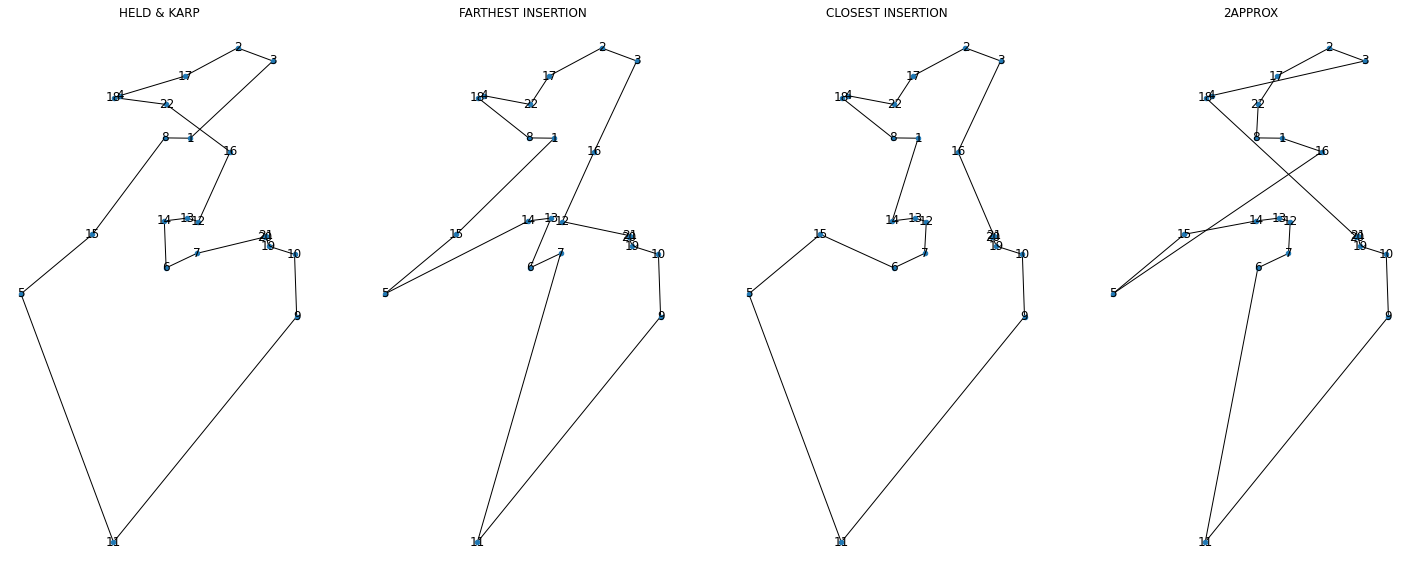

In [7]:
#ulysses22
import DrawingTest as draw
farth = [1,3,2,17,4,18,22,16,12,13,14,6,7,20,21,19,10,9,11,5,15,8]
clos = [8, 18, 4, 22, 17, 2, 3, 16, 12, 21, 20, 19, 10, 9, 11, 7, 6, 13, 14, 5, 15, 1]
held = [1, 14, 13, 12, 7, 6, 15, 5, 11, 9, 10, 19, 20, 21, 16, 3, 2, 17, 22, 4, 18, 8]
twoapprox = [6,7,12,13,14,15,5,16,1,8,22,17,2,3,4,18,20,21,19,10,9,11]

k= []
k.append(farth)
k.append(clos)
k.append(held)
k.append(twoapprox)

draw.drawPath('ulysses22.tsp', k)